In [43]:
!nvidia-smi

Tue Dec 15 10:04:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 40%   58C    P2   268W / 280W |  23600MiB / 24220MiB |     92%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 62%   79C    P2   112W / 280W |  14370MiB / 24220MiB |     60%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
######### IMPORTING NECESSARY MODULES #########
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import torch.optim as optim
from torchvision import models


sys.path.append('/home/ironman/abhishek/AliProducts/architectures/')
sys.path.append('/home/ironman/abhishek/AliProducts/Helper/')
from dataloader import mydataset, create_prime_dict 
from trainer_cutmix import train, test_classify, eval_classify
from resnet_models import ResNet,Bottleneck
from Load_model import load
from plot_curves import plot_loss, plot_acc


from collections import defaultdict

In [3]:
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:7


**Dataloading Scheme**

In [4]:
trainlist = '/home/ironman/abhishek/AliProducts/Newlist/NEW_train_list1.txt'
validlist = '/home/ironman/abhishek/AliProducts/Newlist/NEW_valid_list1.txt'

In [5]:
prime_dict = create_prime_dict(trainlist)

Number of classes =  50030


In [6]:
#### Train Dataloader #### 
train_dataset = mydataset(trainlist, prime_dict, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 64, num_workers=16,pin_memory=True)


#### Validation Dataloader #### 
validation_dataset = mydataset(validlist, prime_dict, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 64, num_workers=16,pin_memory=True)

**Model Definition**

In [7]:
model = models.resnext101_32x8d(pretrained = False, num_classes = 50030)

model = nn.DataParallel(model,device_ids=[7,6]).to(device)
model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

**Hyperparameters**

In [8]:
## Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 25, gamma = 0.1)

# Epochs
num_Epochs = 90

beta=1

cutmix_prob = 1

In [9]:
modelname = 'NewData_Apro_AA_Cutmix_ResNeXt101_32x8d'
modelpath = '/home/ironman/abhishek/saved_model_checkpoints/AliProducts/'+modelname

In [10]:
train(model, train_dataloader, validation_dataloader, beta, cutmix_prob, criterion, optimizer, lr_scheduler, modelpath, writer, device=device, epochs = num_Epochs)

writer.flush()
writer.close()

NameError: name 'writer' is not defined

In [10]:
#### Load saved model from checkpoint  #####
model, optimizer, lr_scheduler, train_loss, v_loss, v_acc, epoch = load(modelpath, model, optimizer, lr_scheduler)


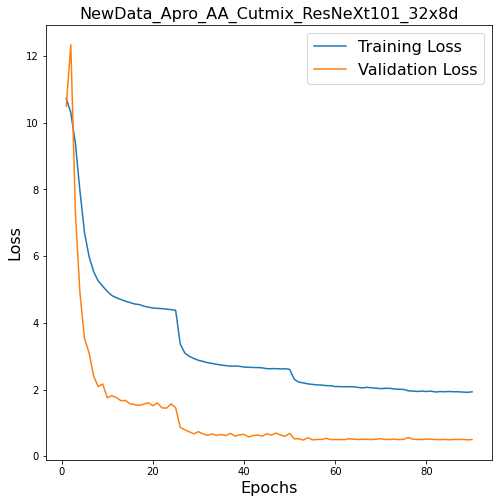

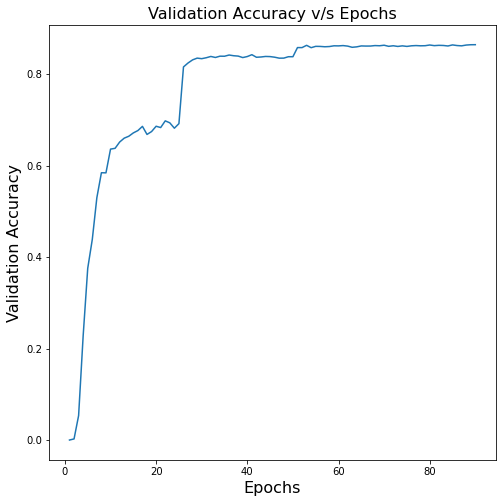

In [12]:
#### Plot Loss Curves ####
plot_loss(epoch, train_loss, v_loss, title = 'NewData_Apro_AA_Cutmix_ResNeXt101_32x8d')
plot_acc(epoch, v_acc)


In [11]:
t_loss,top1_t_acc, top5_t_acc =test_classify(model, train_dataloader, criterion, device)
print('Training Loss: {:.4f}\tTop 1 Training Accuracy: {:.4f}\t Top 5 Training Accuracy: {:.4f}'.format(t_loss, top1_t_acc, top5_t_acc))

Training Loss: 0.3611	Top 1 Training Accuracy: 0.9128	 Top 5 Training Accuracy: 0.9840


In [42]:
v_loss, top1_acc, accuracy_dict= eval_classify(model, validation_dataloader, criterion, device)
print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}\nAccuracy:{}\t'.format(v_loss, top1_acc, accuracy_dict))

KeyboardInterrupt: 

In [12]:
def inverse_prime_dict(prime_dict):
    
    inverse_prime_dict = {}
    
    for key in prime_dict.keys():
        
        inverse_prime_dict[prime_dict[key]] = key
    
    return inverse_prime_dict

inverse_dict = inverse_prime_dict(prime_dict) 


In [13]:
'''
Error Analysis

misclassified into which class

error_dict: classes: misclassified class: number of times

error_dict_count: classes:number of times misclassified
'''


def error_analysis(model, test_loader, criterion, inverse_dict, device):
    model.eval()
    test_loss = []
    top1_accuracy = 0
    top5_accuracy = 0
    total = 0
    
    error_dict = defaultdict(lambda:defaultdict(int))
    error_dict_count = defaultdict(int)

    for batch_num, (feats, labels) in enumerate(test_loader):
        feats, labels = feats.to(device), labels.to(device)
        outputs = model(feats) 
        
        '''
        find loss
        '''
        loss = criterion(outputs, labels.long())
        test_loss.extend([loss.item()]*feats.size()[0])
        
        
        '''
        Predictions
        '''
        predictions = F.softmax(outputs, dim=1)
                
            
        '''
        Top1 Accuracy
        '''
        _, top1_pred_labels = torch.max(predictions,1)
        top1_pred_labels = top1_pred_labels.view(-1)
        
        top1_accuracy += torch.sum(torch.eq(top1_pred_labels, labels)).item()
        
        
        '''
        Misclassified instances
        '''
        
        for i in range(len(labels)):

            if not torch.eq(labels[i],top1_pred_labels[i]):
                
                actual = inverse_dict[labels[i].item()]
                predicted = inverse_dict[top1_pred_labels[i].item()]
                
                error_dict[actual][predicted]+=1
                error_dict_count[actual]+=1
                


                
        total += len(labels)
        
        
    model.train()
    return np.mean(test_loss), top1_accuracy/total, error_dict, error_dict_count

In [15]:
loss, top1, error_dict, error_dict_count = error_analysis(model, validation_dataloader, criterion, inverse_dict, device)

In [42]:
error_dict['903']

defaultdict(int, {'18529': 4})

In [35]:
len(error_dict_count)

12499

In [19]:
def sorted_dict(dictionary):
    
    sorted_keys = sorted(dictionary, key =dictionary.__getitem__, reverse=True)
    sorted_values = sorted(dictionary.values(),reverse=True)
    
    sorted_dictionary = {}
    for i in range(len(sorted_keys)):
        sorted_dictionary[sorted_keys[i]] = sorted_values[i]
        
    return sorted_dictionary

In [37]:
sorted_dict(error_dict_count)

{'217': 4,
 '241': 4,
 '282': 4,
 '395': 4,
 '499': 4,
 '600': 4,
 '606': 4,
 '630': 4,
 '663': 4,
 '758': 4,
 '766': 4,
 '903': 4,
 '946': 4,
 '1078': 4,
 '1155': 4,
 '1229': 4,
 '1246': 4,
 '1336': 4,
 '1427': 4,
 '1450': 4,
 '1470': 4,
 '1588': 4,
 '1633': 4,
 '1637': 4,
 '1667': 4,
 '1732': 4,
 '1744': 4,
 '1757': 4,
 '1797': 4,
 '1802': 4,
 '1837': 4,
 '1853': 4,
 '1857': 4,
 '1861': 4,
 '1935': 4,
 '1950': 4,
 '1992': 4,
 '2019': 4,
 '2040': 4,
 '2066': 4,
 '2070': 4,
 '2081': 4,
 '2248': 4,
 '2264': 4,
 '2302': 4,
 '2329': 4,
 '2334': 4,
 '2375': 4,
 '2404': 4,
 '2440': 4,
 '2468': 4,
 '2469': 4,
 '2528': 4,
 '2540': 4,
 '2545': 4,
 '2559': 4,
 '2593': 4,
 '2642': 4,
 '2730': 4,
 '2733': 4,
 '2760': 4,
 '2823': 4,
 '2858': 4,
 '2871': 4,
 '2922': 4,
 '3181': 4,
 '3207': 4,
 '3250': 4,
 '3258': 4,
 '3259': 4,
 '3261': 4,
 '3311': 4,
 '3392': 4,
 '3396': 4,
 '3431': 4,
 '3451': 4,
 '3453': 4,
 '3467': 4,
 '3494': 4,
 '3564': 4,
 '3684': 4,
 '3696': 4,
 '3732': 4,
 '3881': 4,
 '391

In [22]:
'''
See where error is coming from, i.e from classes <30 samples or from more than 30 samples
represented_dict- whether a class is higly represented or less represented (more than 30 samples or not)
'''

'''
load classes
'''
f = open('classes_more_than_30_images_list','r')
highly_represented =f.readlines()
f.close()
highly_represented = [i[:-1] for i in highly_represented]    

f = open('classes_less_than_30_images_list','r')
less_represented =f.readlines()
f.close()
less_represented=[i[:-1] for i in less_represented]

represented_dict = defaultdict(int)

for key in error_dict_count:
    if key in highly_represented:
        represented_dict['highly represented'] +=1
    else:
        represented_dict['less represented'] +=1
    

In [23]:
represented_dict

defaultdict(int, {'less represented': 7943, 'highly represented': 4556})